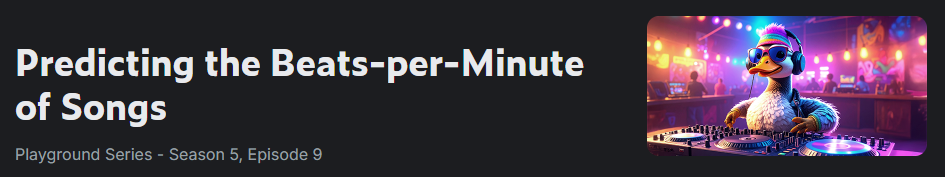
* https://www.kaggle.com/competitions/playground-series-s5e9
* 위 공모전의 목표: 주어진 노래의 여러 특징(feature)들을 기반으로 해당 곡의 BPM(박자 수) 을 예측하는 것

In [1]:
# 파이썬 기본 라이브러리
import math
import warnings

# 데이터 분석 및 시각화 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 주피터 노트북 환경 설정용
from IPython.display import display, HTML

# Scikit-learn (머신러닝) 라이브러리
import sklearn

# 데이터 분할 및 교차 검증
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_validate,
    GridSearchCV,
)

# 회귀 모델 (선형, 트리, 앙상블, SVM)
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR

# 데이터 전처리 및 특성 공학 (스케일러, 변환)
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    FunctionTransformer,
)

# 파이프라인 및 특성 선택
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

# 타깃 변수 변환
from sklearn.compose import TransformedTargetRegressor

# 모델 평가 지표
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
)

# 부스팅 계열 모델 (XGBoost, LightGBM, ...)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor

# 실행 환경 설정: 경고 메시지 무시
warnings.filterwarnings(action='ignore')

# 시각화 기본 스타일 설정 (Seaborn)
sns.set()

# 시각화 한글 폰트 및 마이너스 부호 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 주피터 노트북 셀 너비 확장
display(HTML("<style>.container{width:100% !important;}</style>"))

# Pandas 데이터프레임 출력 옵션 설정
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

# Data Load

In [2]:
df = pd.read_csv('../data/train.csv')
df.head()

id  RhythmScore  AudioLoudness  VocalContent  AcousticQuality  \
0   0     0.603610      -7.636942      0.023500         0.000005   
1   1     0.639451     -16.267598      0.071520         0.444929   
2   2     0.514538     -15.953575      0.110715         0.173699   
3   3     0.734463      -1.357000      0.052965         0.001651   
4   4     0.532968     -13.056437      0.023500         0.068687   

   InstrumentalScore  LivePerformanceLikelihood  MoodScore  TrackDurationMs  \
0           0.000001                   0.051385   0.409866      290715.6450   
1           0.349414                   0.170522   0.651010      164519.5174   
2           0.453814                   0.029576   0.423865      174495.5667   
3           0.159717                   0.086366   0.278745      225567.4651   
4           0.000001                   0.331345   0.477769      213960.6789   

     Energy  BeatsPerMinute  
0  0.826267       147.53020  
1  0.145400       136.15963  
2  0.624667        55.31989  
3  0.487467       147.91212  
4  0.947333        89.58511

# EDA

| 약어 (Abbr.) | 전체 이름 (Full Name)           | 한 줄 요약 설명 |
|:-------------:|:--------------------------------:|:----------------|
| <font color=yellow>---</font> | <font color=yellow>기본 피쳐</font> | <font color=yellow>---</font> |
| **rs**  | RhythmScore | 리듬의 복잡성이나 규칙성을 나타내는 점수 |
| **al**  | AudioLoudness | 노래의 전체적인 평균 음량 (데시벨) |
| **vc**  | VocalContent | 노래에서 보컬(목소리)이 차지하는 비중 |
| **aq**  | AcousticQuality | 음악이 얼마나 '어쿠스틱'한지(전자음이 적은지) 나타내는 척도 |
| **is**  | InstrumentalScore | 노래에서 악기 연주가 차지하는 비중 |
| **lpl** | LivePerformanceLikelihood | 이 곡이 라이브 공연일 가능성 |
| **ms**  | MoodScore | 곡의 전반적인 분위기(예: 긍정, 부정)를 나타내는 점수 |
| **tdm** | TrackDurationMs | 노래의 총 길이 (밀리초 단위) |
| **e**   | Energy | 노래의 에너지 레벨, 즉 강렬하고 활기찬 정도 |
| **bpm** | BeatsPerMinute | (타겟 변수) 1분당 비트 수, 즉 노래의 빠르기 |
| <font color=yellow>---</font> | <font color=yellow>파생 피쳐</font> | <font color=yellow>---</font> |
| **tdm** | TrackDurationMin | tdm(밀리초)을 분(minute) 단위로 변환한 노래의 길이 |
| **ear** | Energy_Acoustic_Ratio | 에너지 대비 어쿠스틱함의 비율로, 전자음악/어쿠스틱 성향을 나타냄 |
| **vib** | Vocal_Instrument_Balance | 보컬과 악기 사운드의 균형을 나타내는 지표 |
| **mr**  | MoodRhythm | 분위기(Mood)와 리듬감(Rhythm)의 시너지 효과를 나타내는 점수 |
| **pi**  | PerformanceIntensity | 라이브 공연의 강렬함 또는 현장감을 나타내는 지표 |
| **re**  | RhythmEnergy | 리듬의 활기 또는 댄스 가능성을 나타내는 에너지 점수 |
| **ma**  | MoodAcoustic | 음악의 분위기와 어쿠스틱 특성의 조합을 나타내는 값 |

* 학습에 필요없는 id 컬럼 드랍
* 컬럼명 변경

In [3]:
df = df.drop('id', axis=1)
df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e', 'bpm']
df.head()

rs         al        vc        aq        is       lpl        ms  \
0  0.603610  -7.636942  0.023500  0.000005  0.000001  0.051385  0.409866   
1  0.639451 -16.267598  0.071520  0.444929  0.349414  0.170522  0.651010   
2  0.514538 -15.953575  0.110715  0.173699  0.453814  0.029576  0.423865   
3  0.734463  -1.357000  0.052965  0.001651  0.159717  0.086366  0.278745   
4  0.532968 -13.056437  0.023500  0.068687  0.000001  0.331345  0.477769   

           tdm         e        bpm  
0  290715.6450  0.826267  147.53020  
1  164519.5174  0.145400  136.15963  
2  174495.5667  0.624667   55.31989  
3  225567.4651  0.487467  147.91212  
4  213960.6789  0.947333   89.58511

* 결측 없고 다 수치형

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   rs      524164 non-null  float64
 1   al      524164 non-null  float64
 2   vc      524164 non-null  float64
 3   aq      524164 non-null  float64
 4   is      524164 non-null  float64
 5   lpl     524164 non-null  float64
 6   ms      524164 non-null  float64
 7   tdm     524164 non-null  float64
 8   e       524164 non-null  float64
 9   bpm     524164 non-null  float64
dtypes: float64(10)
memory usage: 40.0 MB


* 히스토그램
* 오른쪽으로 치우치고(왜도 > 0) 매우 뾰족한(첨도 > 3) 분포: vc, aq, is, lpl
* 왼쪽으로 살짝 치우친(왜도 < 0) 분포: al
* ms의 중간값이 비어 보이는 건 음악의 분위기가 어중간하기보다 확실히 밝거나 확실히 어둡다는 특성을 보여주는 결과
* ms는 데이터에 오류가 있다기보다는, 음악 자체가 가진 본질적인 특성일 가능성이 매우 높음

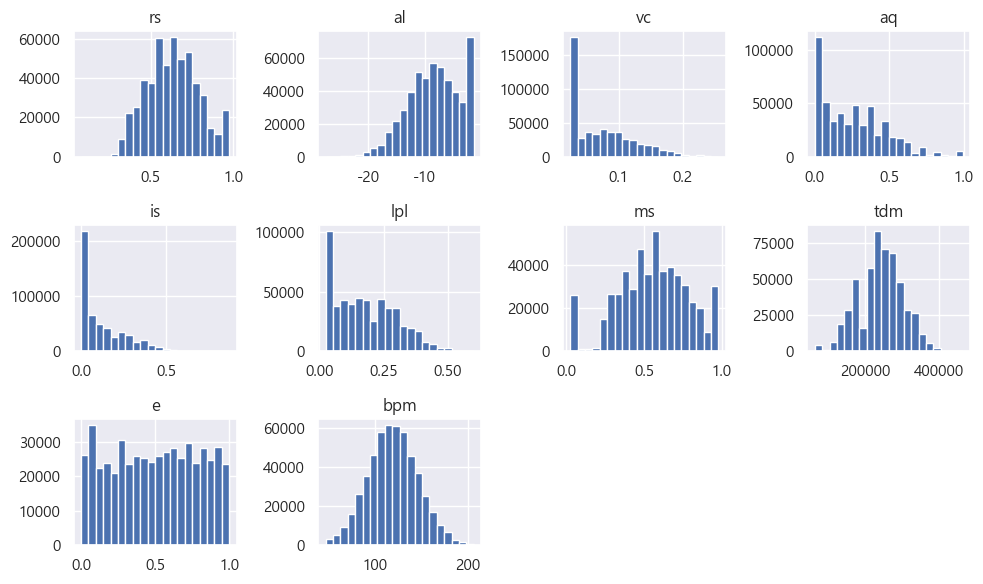

In [5]:
df.hist(figsize=(10, 6), bins=20, layout=(3, 4))
plt.tight_layout()
plt.show()

* 오른쪽으로 심하게 치우친 변수들 (vc, aq, is, lpl, tdm)
* 이 피쳐들은 대부분의 값이 낮은 쪽에 몰려있고, 아웃라이어가 많이 존재
* 왼쪽으로 치우친 변수들 (rs, al, tdm)
* 이 피쳐들은 반대로 대부분의 값이 높은 쪽에 몰려있고, 아웃라이어가 일부 존재

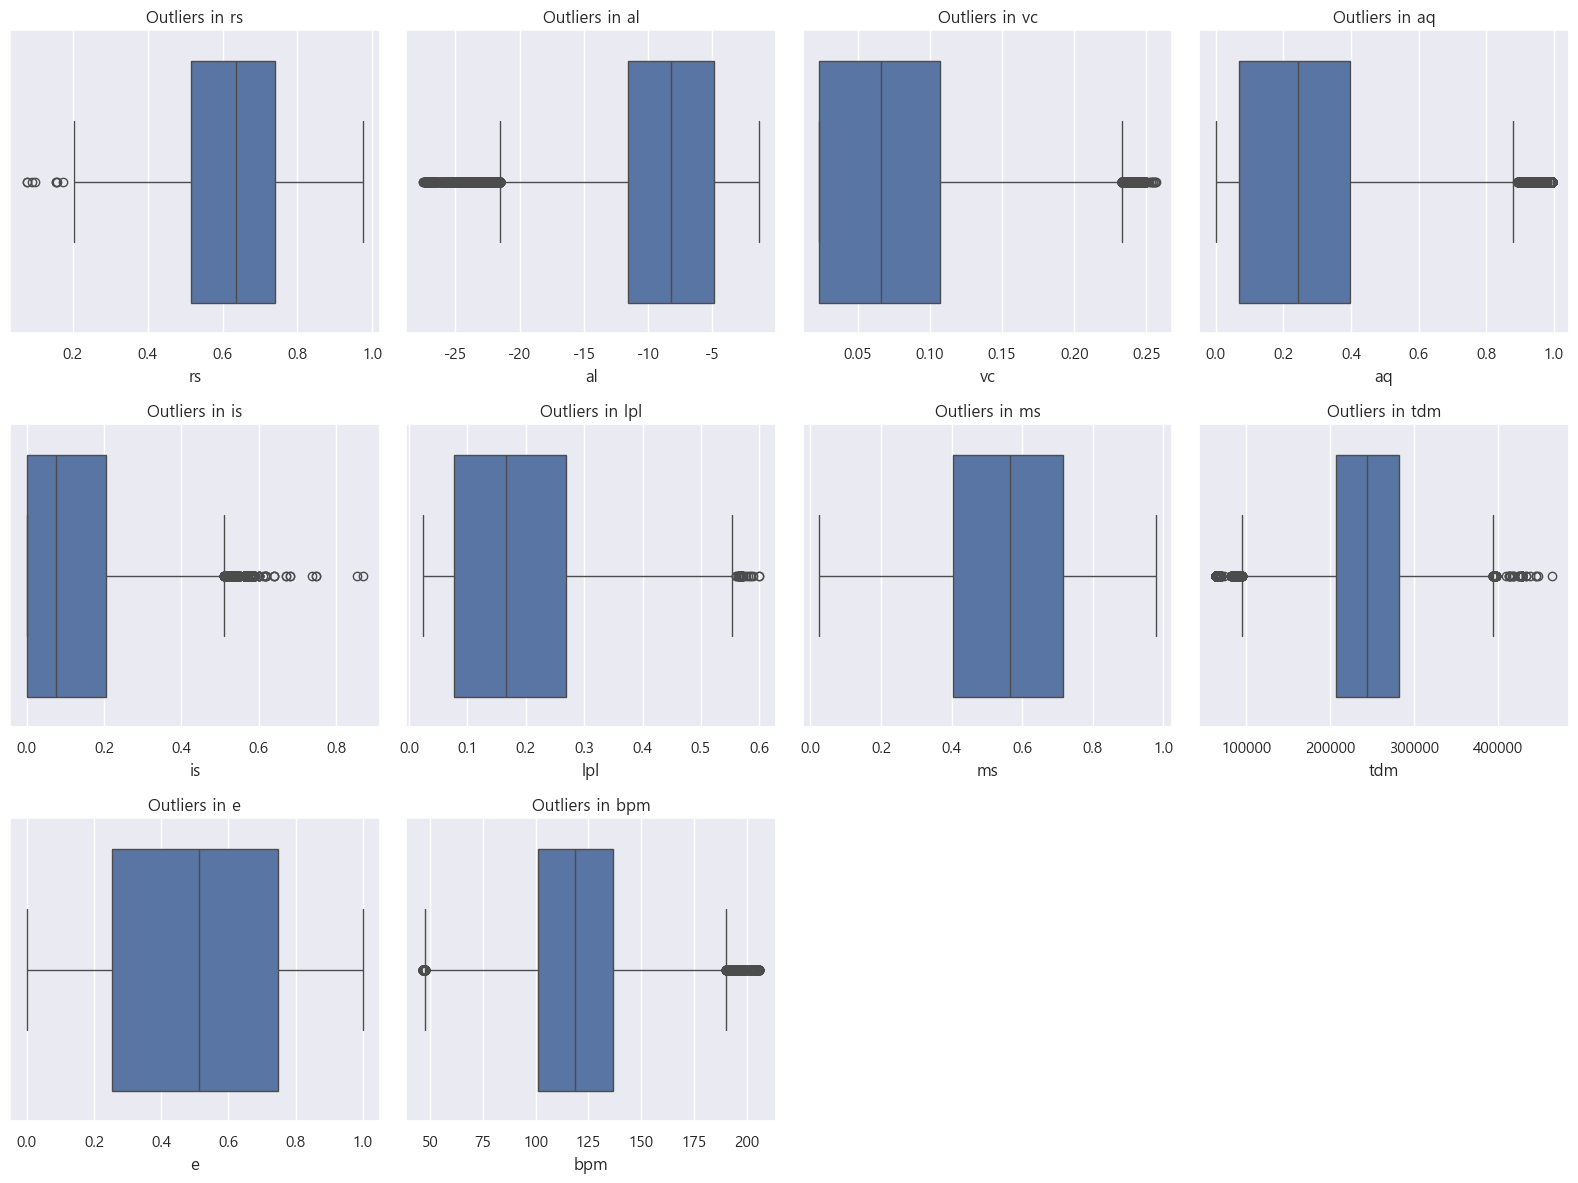

In [6]:
# 3x4 격자 형태의 서브플롯(그래프 틀) 생성
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten() # 2차원 배열의 axes를 1차원으로 변환하여 다루기 쉽게 함

# 데이터프레임의 각 열(column)에 대해 반복하여 박스 플롯(boxplot) 생성
for i, col in enumerate(df.columns):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"Outliers in {col}")

# 데이터프레임의 열 개수보다 서브플롯 개수가 많을 경우, 남는 플롯은 숨김 처리
for j in range(len(df.columns), len(axes)):
    axes[j].axis('off')

# 플롯 간 간격을 자동으로 조절하여 겹치지 않게 함
plt.tight_layout()

# 최종 그래프 출력
plt.show()

* 원본 데이터프레임을 따로 저장

In [7]:
dforg = df.copy()

# 공통함수

In [ ]:
def preprocess(df):
    if(df == train):
        test_df = pd.read_csv('../data/test.csv')
        test_ids = test_df['id']
        test_df = test_df.drop('id', axis=1)
        test_df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e']
    
    elif(df == test):
        test_df = pd.read_csv('../data/test.csv')
        test_ids = test_df['id']
        test_df = test_df.drop('id', axis=1)
        test_df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e']
        